# Import the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import datasets, linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Importing the dataset

In [2]:
import os
os.chdir(r'C:\Users\nikhi\Desktop\MSc DS\1-Machine Learning\project\Assignment 2')
df = pd.read_excel('TrainDataset2023.xls')

In [3]:

#df = pd.read_excel('TrainDataset2023.xls')

In [4]:
# removing the index column
df.drop("ID",inplace=True,axis=1)

In [5]:
missing_columns = ["pCR (outcome)","PgR","HER2","TrippleNegative","ChemoGrade","Proliferation","HistologyType","LNStatus"]

In [6]:
#Replacing '999' as null
values_to_replace=999
df.replace(values_to_replace,np.NaN ,inplace = True)

In [7]:
#columns which have null values
df.columns[df.isnull().any()]

Index(['pCR (outcome)', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade',
       'Proliferation', 'HistologyType', 'LNStatus'],
      dtype='object')

In [8]:
# Imputing missing values with the mode of that particular column
m1 = (df["PgR"].mode()[0])
df["PgR"].fillna(value= m1,inplace=True)
df["PgR"].value_counts()


m2 = (df["HER2"].mode()[0])
df["HER2"].fillna(value= m2 , inplace =True) 

m3 = (df["TrippleNegative"].mode()[0])
df["TrippleNegative"].fillna(value= m3 , inplace =True) 

m4 = (df["ChemoGrade"].mode()[0])
df["ChemoGrade"].fillna(value= m4, inplace =True) 

m5 = (df["Proliferation"].mode()[0])
df["Proliferation"].fillna(value= m5 , inplace =True)

m6 = (df["HistologyType"].mode()[0])
df["HistologyType"].fillna(value= m6 , inplace =True) 

m7 = (df["LNStatus"].mode()[0])
df["LNStatus"].fillna(value= m7 , inplace =True) 

In [9]:
df.columns[df.isnull().any()]

Index(['pCR (outcome)'], dtype='object')

# Splitting X and Y

In [10]:
X = df.iloc[:, 2:]
y = df['RelapseFreeSurvival (outcome)']

# PCA for clinical features

In [11]:
# Clinical features
df1= df.iloc[:,1:12] #exculding pcr column
print(df1.shape)

(400, 11)


In [12]:
# Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x1s = scaler.fit_transform(df1)

In [13]:
# PCA
pca1 = PCA(n_components=9)
x1s_pca = pca1.fit_transform(x1s)
print(pca1.explained_variance_ratio_)
print(sum(pca1.explained_variance_ratio_))

[0.27467933 0.13556503 0.12405169 0.1032879  0.08948942 0.08844175
 0.07490354 0.05516661 0.02825814]
0.9738434049293073


# PCA for MRI features

In [14]:
df2=df.iloc[:,12:119]
print(df2.shape)

(400, 107)


In [15]:
# normalisation
scaler = StandardScaler()
x2s = scaler.fit_transform(df2)

In [16]:
# PCA
pca2 = PCA(n_components=15)
pca2 = pca2.fit(x2s)
x2s_pca = pca2.fit_transform(x2s)
print(pca2.explained_variance_ratio_)
print(sum(pca2.explained_variance_ratio_))

[0.32603751 0.14592156 0.12252538 0.11409695 0.06188648 0.04810373
 0.03132576 0.02147648 0.01981842 0.01295962 0.01127472 0.01079507
 0.00980568 0.00846477 0.00707815]
0.9515702992265545


# Merging the end results of both PCA

In [17]:
import numpy as np
p_dff = np.concatenate((x1s_pca,x2s_pca),axis=1)

In [18]:
PCA_dff = pd.DataFrame()
for i in range(24):
    PCA_dff[i]= p_dff[:,i]
PCA_dff.shape

(400, 24)

# lassoCV for feature selection

In [19]:
from sklearn.linear_model import LassoCV
model1 = LassoCV(cv=5, random_state=0, max_iter=10000)
model1.fit(PCA_dff, y)
model1.alpha_

0.021429886674678496

In [20]:
# Set best alpha
from sklearn.linear_model import Lasso
lasso_best1 = Lasso(alpha=model1.alpha_)
lasso_best1.fit(PCA_dff, y)
lasso_best1.coef_

array([-1.34535434e+00, -6.12063626e+00, -6.78743092e+00, -4.75617704e+00,
        2.17479865e+01,  1.56402250e+00,  1.07078442e+01, -5.61485012e+00,
       -5.62919196e-01, -0.00000000e+00,  2.00443990e-03, -7.03124274e-03,
        2.93806196e-03,  8.16189368e-03,  1.39495655e-02,  1.27353553e-03,
       -3.29025963e-03,  1.03884480e-02, -0.00000000e+00, -3.72586192e-04,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00])

In [21]:
col = PCA_dff.columns

a = lasso_best1.coef_
b = np.array(col)[a!=0]

las_dff = pd.DataFrame()
for i in range(len(b)):
    v=b[i]
    las_dff[i]= PCA_dff[v]

las_dff.shape

(400, 18)

# Data Visualization

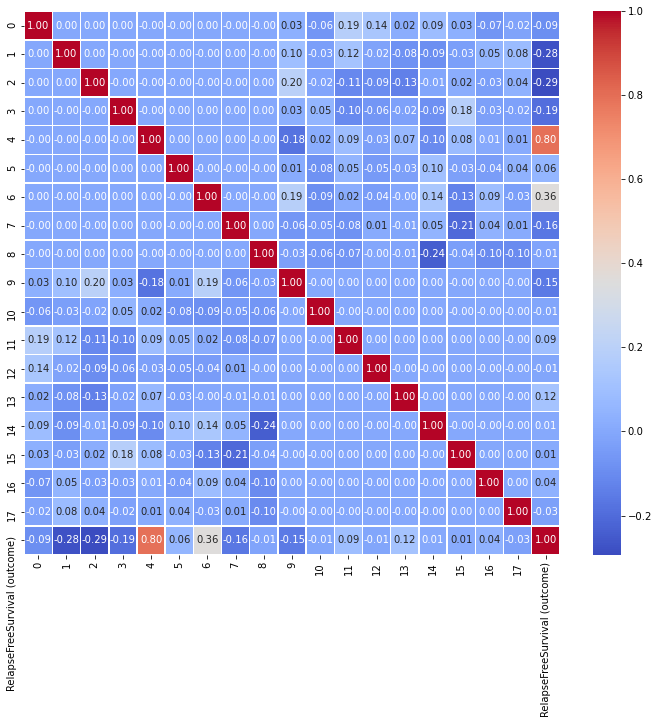

In [22]:
#Visualising the selected features using correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.concat([las_dff, y], axis=1)

correlation_matrix = data.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.show()

# Train test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(las_dff, y, test_size = 0.1, random_state = 42)

# Random Forest model

In [24]:
rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)


rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)
rf_mae = mean_absolute_error(y_test, rf_y_pred)

print(f'Random Forest Mean Squared Error: {rf_mse}')
print(f'Random Forest R-squared: {rf_r2}')
print(f'Random Forest Mean Absolute Error: {rf_mae}')

Random Forest Mean Squared Error: 125.34266987847222
Random Forest R-squared: 0.8620374126181525
Random Forest Mean Absolute Error: 8.231895833333335


# Linear Regression Model

In [25]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

linear_y_pred = linear_model.predict(X_test)

linear_mse = mean_squared_error(y_test, linear_y_pred)
linear_r2 = r2_score(y_test, linear_y_pred)
linear_mae = mean_absolute_error(y_test, linear_y_pred)

print(f'Linear Regression Mean Squared Error: {linear_mse}')
print(f'Linear Regression R-squared: {linear_r2}')
print(f'Linear Regression Mean Absolute Error: {linear_mae}')

Linear Regression Mean Squared Error: 0.19019790847215406
Linear Regression R-squared: 0.9997906523325786
Linear Regression Mean Absolute Error: 0.32885187662258153


# Decisison Tree model

In [26]:
tree_model = DecisionTreeRegressor(random_state=90)

tree_model.fit(X_train, y_train)

tree_y_pred = tree_model.predict(X_test)

tree_mse = mean_squared_error(y_test, tree_y_pred)
tree_r2 = r2_score(y_test, tree_y_pred)
tree_mae = mean_absolute_error(y_test, tree_y_pred)

print(f'Decision Tree Mean Squared Error: {tree_mse}')
print(f'Decision Tree R-squared: {tree_r2}')
print(f'Decision Tree Mean Absolute Error: {tree_mae}')

Decision Tree Mean Squared Error: 329.1460069444444
Decision Tree R-squared: 0.6377144767341651
Decision Tree Mean Absolute Error: 14.810416666666665


# SVR model

In [27]:
svr_model = SVR()

svr_model.fit(X_train, y_train)

svr_y_pred = svr_model.predict(X_test)

svr_mse = mean_squared_error(y_test, svr_y_pred)
svr_r2 = r2_score(y_test, svr_y_pred)
svr_mae = mean_absolute_error(y_test, svr_y_pred)

print(f'SVR Mean Squared Error: {svr_mse}')
print(f'SVR R-squared: {svr_r2}')
print(f'SVR Mean Absolute Error: {svr_mae}')

SVR Mean Squared Error: 766.3068953363305
SVR R-squared: 0.15653877397334237
SVR Mean Absolute Error: 20.950233359491207


# Neural Network Model

In [28]:
mlp_model = MLPRegressor(alpha=0.0001, hidden_layer_sizes=(100,), max_iter=1500, random_state=20)

mlp_model.fit(X_train, y_train)
mlp_y_pred = mlp_model.predict(X_test)

mlp_mse = mean_squared_error(y_test, mlp_y_pred)
mlp_r2 = r2_score(y_test, mlp_y_pred)
mlp_mae = mean_absolute_error(y_test, mlp_y_pred)

print(f'Neural Network Mean Squared Error: {mlp_mse}')
print(f'Neural Network R-squared: {mlp_r2}')
print(f'MLP Mean Absolute Error: {mlp_mae}')

Neural Network Mean Squared Error: 24.390995205656452
Neural Network R-squared: 0.9731532381538288
MLP Mean Absolute Error: 3.8565513755605516


C:\Users\nikhi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


# Printing the MLP model parameters

In [29]:
# Get the model parameters
model_params = mlp_model.get_params()

# Display the parameters
print("Model Parameters:")
for param, value in model_params.items():
    print(f"{param}: {value}")

Model Parameters:
activation: relu
alpha: 0.0001
batch_size: auto
beta_1: 0.9
beta_2: 0.999
early_stopping: False
epsilon: 1e-08
hidden_layer_sizes: (100,)
learning_rate: constant
learning_rate_init: 0.001
max_fun: 15000
max_iter: 1500
momentum: 0.9
n_iter_no_change: 10
nesterovs_momentum: True
power_t: 0.5
random_state: 20
shuffle: True
solver: adam
tol: 0.0001
validation_fraction: 0.1
verbose: False
warm_start: False


# Scatter plot for visualising actual and predicted values for the MLP model

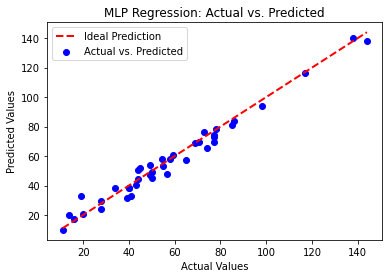

In [30]:
# Scatter plot for actual vs. predicted values
plt.scatter(y_test, mlp_y_pred, color='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Ideal Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('MLP Regression: Actual vs. Predicted')
plt.legend()
plt.show()

# Hyperparameter Tuning for the MLP model

In [31]:
from sklearn.model_selection import GridSearchCV

mlp_model = MLPRegressor(random_state=20)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'max_iter': [500, 1000, 1500],
    'alpha': [0.0001, 0.001, 0.01],
}
grid_search = GridSearchCV(mlp_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

best_mlp_model = grid_search.best_estimator_
mlp_y_pred_hyper = best_mlp_model.predict(X_test)


mlp_mse = mean_squared_error(y_test, mlp_y_pred_hyper)
mlp_r2 = r2_score(y_test, mlp_y_pred_hyper)
mlp_mae = mean_absolute_error(y_test, mlp_y_pred_hyper)

print(f'Best Hyperparameters: {best_params}')
print(f'Neural Network Mean Squared Error: {mlp_mse}')
print(f'Neural Network R-squared: {mlp_r2}')
print(f'Neural Network Mean Absolute Value: {mlp_mae}')

Best Hyperparameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'max_iter': 1500}
Neural Network Mean Squared Error: 24.390995205656452
Neural Network R-squared: 0.9731532381538288
Neural Network Mean Absolute Value: 3.8565513755605516


C:\Users\nikhi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


# Visualisation of the MAE results for each model

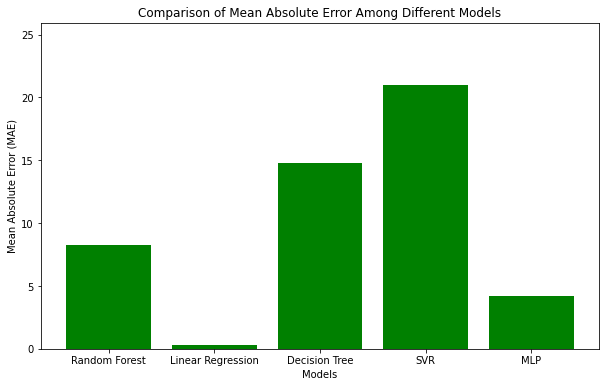

In [32]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
models = ['Random Forest', 'Linear Regression', 'Decision Tree', 'SVR', 'MLP']
mae_values = [8.231895833333335, 0.32885187662258203, 14.810416666666665, 20.950233359491204, 4.237988140826213]

# Plotting bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, mae_values, color='green')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of Mean Absolute Error Among Different Models')
plt.ylim(0, max(mae_values) + 5)  # Adjust the y-axis limits if needed
plt.show()

# Cross validation for the MLP model

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import numpy as np

mlp_model = MLPRegressor(alpha=0.0001,hidden_layer_sizes=(100,), max_iter=1500, random_state=20)
n_folds = 5

# K-fold cross-validation
r2_scores = cross_val_score(mlp_model, X_train, y_train, cv=n_folds, scoring='r2')
mae_scores = cross_val_score(mlp_model, X_train, y_train, cv=n_folds, scoring='neg_mean_absolute_error')

# Average and standard deviation of R-squared values
avg_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

# Average and standard deviation of MAE values
avg_mae = -np.mean(mae_scores)  # Note: negate the MAE scores as cross_val_score returns negative values
std_mae = np.std(-mae_scores)

print("R-squared scores for each fold:", r2_scores)
print(f'\nAverage R-squared: {avg_r2}')
print(f'Standard Deviation of R-squared: {std_r2}')

print("MAE scores for each fold:", -mae_scores)
print(f'Average MAE: {avg_mae}')
print(f'Standard Deviation of MAE: {std_mae}')


C:\Users\nikhi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nikhi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nikhi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nikhi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\nikhi\anaconda3\lib\site-packages\sklearn\neural_network\_m

R-squared scores for each fold: [0.92305856 0.94974911 0.91134957 0.65256588 0.9150258 ]

Average R-squared: 0.8703497839463047
Standard Deviation of R-squared: 0.10971711300735136
MAE scores for each fold: [5.43404946 4.86184661 4.39379601 6.23187192 5.44739346]
Average MAE: 5.273791491612201
Standard Deviation of MAE: 0.619326892620683


C:\Users\nikhi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


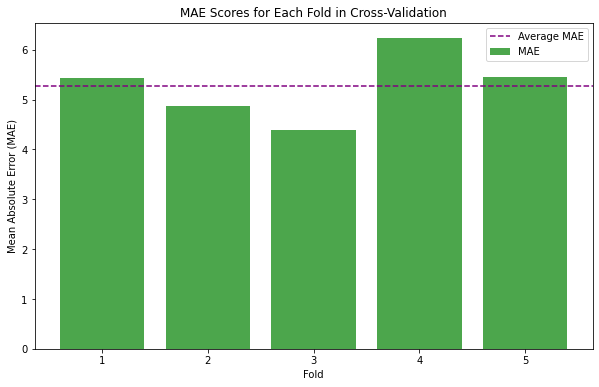

In [34]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_folds + 1), -mae_scores, color='green', alpha=0.7, label='MAE')
plt.axhline(y=avg_mae, color='purple', linestyle='--', label='Average MAE')
plt.xlabel('Fold')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE Scores for Each Fold in Cross-Validation')
plt.legend()
plt.show()

In [35]:
# For pipeline creation.

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

# Define the first and second part of the pipeline
pipeline1 = Pipeline([
    ('scaler1', StandardScaler()),
    ('pca1', PCA(n_components=9))
])

pipeline2 = Pipeline([
    ('scaler2', StandardScaler()),
    ('pca2', PCA(n_components=15))
])

# Combine both parts using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('first_split', pipeline1, slice(0, 12)),
        ('second_split', pipeline2, slice(12, X.shape[1]))
    ])

# Placeholder for the model, to be specified later
model_placeholder = RandomForestClassifier()  # Default model

# Final pipeline
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model_placeholder)
])



In [37]:
from sklearn.model_selection import train_test_split

df = pd.read_excel('TrainDataset2023.xls')

df.drop("ID",inplace=True,axis=1)

X = df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)
y_rfs = df['RelapseFreeSurvival (outcome)']  

X_train_rfs, X_test_rfs, y_train_rfs, y_test_rfs = train_test_split(X, y_rfs, test_size=0.2, random_state=42)


In [38]:
final_pipeline.set_params(model=MLPRegressor(random_state=20))
final_pipeline.fit(X_train_rfs, y_train_rfs)
predictions_rfs = final_pipeline.predict(X_test_rfs)

C:\Users\nikhi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [39]:
final_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('first_split',
                                                  Pipeline(steps=[('scaler1',
                                                                   StandardScaler()),
                                                                  ('pca1',
                                                                   PCA(n_components=9))]),
                                                  slice(0, 12, None)),
                                                 ('second_split',
                                                  Pipeline(steps=[('scaler2',
                                                                   StandardScaler()),
                                                                  ('pca2',
                                                                   PCA(n_components=15))]),
                                                  slice(12, 117, None))])),
                ('model', ML

In [43]:
with open("final_pipeline.pkl","wb") as f:
   pickle.dump(final_pipeline,f)

In [42]:
import pickle